##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text generation with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate text using a character-based RNN. You will work with a dataset of Shakespeare's writing from Andrej Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Given a sequence of characters from this data ("Shakespear"), train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

Note: Enable GPU acceleration to execute this notebook faster. In Colab: *Runtime > Change runtime type > Hardware accelerator > GPU*.

This tutorial includes runnable code implemented using [tf.keras](https://www.tensorflow.org/guide/keras/sequential_model) and [eager execution](https://www.tensorflow.org/guide/eager). The following is the sample output when the model in this tutorial trained for 30 epochs, and started with the prompt "Q":

<pre>
QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.

VOLUMNIA:
O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
And love and pale as any will to that word.

QUEEN ELIZABETH:
But how long have I heard the soul for this world,
And show his hands of life be proved to stand.

PETRUCHIO:
I say he look'd on, if I must be content
To stay him from the fatal of our country's bliss.
His lordship pluck'd from this sentence then for prey,
And then let us twain, being the moon,
were she such a case as fills m
</pre>

While some of the sentences are grammatical, most do not make sense. The model has not learned the meaning of words, but consider:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text.

* The structure of the output resembles a play—blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* As demonstrated below, the model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.

## Setup

### Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

### Download the Shakespeare dataset

Change the following line to run this code on your own data.

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

### Read the data

First, look in the text:

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## Process the text

### Vectorize the text

Before training, you need to convert the strings to a numerical representation.

The `tf.keras.layers.StringLookup` layer can convert each character into a numeric ID. It just needs the text to be split into tokens first.

In [ ]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Now create the `tf.keras.layers.StringLookup` layer:

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

It converts from tokens to character IDs:

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Since the goal of this tutorial is to generate text, it will also be important to invert this representation and recover human-readable strings from it. For this you can use `tf.keras.layers.StringLookup(..., invert=True)`.  

Note: Here instead of passing the original vocabulary generated with `sorted(set(text))` use the `get_vocabulary()` method of the `tf.keras.layers.StringLookup` layer so that the `[UNK]` tokens is set the same way.

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

This layer recovers the characters from the vectors of IDs, and returns them as a `tf.RaggedTensor` of characters:

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

You can `tf.strings.reduce_join` to join the characters back into strings.

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task you're training the model to perform. The input to the model will be a sequence of characters, and you train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?


### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100


The `batch` method lets you easily convert these individual characters to sequences of the desired size.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


It's easier to see what this is doing if you join the tokens back into strings:

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For training you'll need a dataset of `(input, label)` pairs. Where `input` and
`label` are sequences. At each time step the input is the current character and the label is the next character.

Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep:

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Create training batches

You used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, you need to shuffle the data and pack it into batches.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Build The Model

This section defines the model as a `keras.Model` subclass (For details see [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)).

This model has three layers:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map each character-ID to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use an LSTM layer here.)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs. It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![A drawing of the data passing through the model](images/text_generation_training.png)

Note: For training you could use a `keras.Sequential` model here. To  generate text later you'll need to manage the RNN's internal state. It's simpler to include the state input and output options upfront, than it is to rearrange the model architecture later. For more details see the [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse).

## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [ ]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  16896     
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 dense_1 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


To get actual predictions from the model you need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.

Try it for the first example in the batch:

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [ ]:
sampled_indices

array([49,  9, 36, 29,  9, 47, 32, 65, 26, 14, 34, 28, 61,  9,  3, 19, 15,
       36, 52, 26, 57, 29,  1, 43, 21, 13, 61, 48, 45, 35, 45, 10, 64, 14,
        6, 51, 22, 54, 65, 23, 50, 37, 38, 65, 65,  7, 41, 31, 59, 26, 40,
        1, 23, 42, 28, 62,  8, 60, 51, 63, 53,  3, 64, 56, 18, 62, 27, 34,
       46, 25, 54,  6, 14, 58, 26,  4,  1, 17, 15, 19, 58, 61, 38, 53, 16,
       10, 64, 40, 16, 36, 13,  0, 53, 31,  5,  2, 28, 63,  0,  8])

Decode these to see the text predicted by this untrained model:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'n murders and in outrage, boldly here;\nBut when from under this terrestrial ball\nHe fires the proud '

Next Char Predictions:
 b"j.WP.hSzMAUOv.!FBWmMrP\ndH?vifVf3yA'lIozJkXYzz,bRtMa\nJcOw-ulxn!yqEwNUgLo'AsM$\nDBFsvYnC3yaCW?[UNK]nR& Ox[UNK]-"


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because your model returns logits, you need to set the `from_logits` flag.


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.189922, shape=(), dtype=float32)


A newly initialized model shouldn't be too sure of itself, the output logits should all have similar magnitudes. To confirm this you can check that the exponential of the mean loss is approximately equal to the vocabulary size. A much higher loss means the model is sure of its wrong answers, and is badly initialized:

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.01763

Configure the training procedure using the `tf.keras.Model.compile` method. Use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [ ]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

To keep training time reasonable, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.

In [ ]:
EPOCHS = 20

Epoch 1/20
172/172 [==============================] - 14s 61ms/step - loss: 2.7246
Epoch 2/20
172/172 [==============================] - 11s 58ms/step - loss: 1.9936
Epoch 3/20
172/172 [==============================] - 12s 58ms/step - loss: 1.7129
Epoch 4/20
172/172 [==============================] - 12s 59ms/step - loss: 1.5506
Epoch 5/20
172/172 [==============================] - 12s 60ms/step - loss: 1.4516
Epoch 6/20
172/172 [==============================] - 12s 59ms/step - loss: 1.3838
Epoch 7/20
172/172 [==============================] - 11s 58ms/step - loss: 1.3306
Epoch 8/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2854
Epoch 9/20
172/172 [==============================] - 11s 57ms/step - loss: 1.2439
Epoch 10/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2035
Epoch 11/20
172/172 [==============================] - 12s 60ms/step - loss: 1.1629
Epoch 12/20
172/172 [==============================] - 12s 59ms/step - loss: 1.1216
E

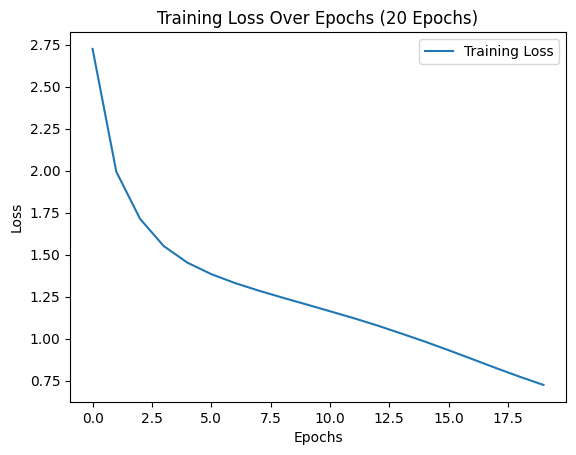

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
#TO-DO: Plot the larning curve for the training data
training_loss = history.history['loss'] # Get the training loss from history

# Plot the learning curve
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (20 Epochs)')
plt.legend()
plt.show()
# This shows us the learning curve because if the training loss decreases over the epochs, the model is learning

## Generate text

The simplest way to generate text with this model is to run it in a loop, and keep track of the model's internal state as you execute it.

![To generate text the model's output is fed back to the input](images/text_generation_sampling.png)

Each time you call the model you pass in some text and an internal state. The model returns a prediction for the next character and its new state. Pass the prediction and state back in to continue generating text.


The following makes a single step prediction:

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Run it in a loop to generate some text. Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)
#TO-DO: Discuss the general sentiment, coherence, Shakespeare-like qualities, and nature of the generated text.
#ANSWER: It attempts to mimic Shakespeare-like qualities by the word choice but it lacked a precision or rythm for it to
#have good coherence. As for the sentiment, I'm not quite sure if that was clearly set since we jumped from topic to
#topic starting with a romantic/ political conversation and then suddenly bringing in 'first murderer'

#TO-DO: Change Romeo to Juliet
start = time.time()
states = None
next_char = tf.constant(['JULIET:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)
#TO-DO: Discuss the general sentiment, coherence, Shakespeare-like qualities, and nature of the generated text.
#The sentiment here seems to be much clearer with it being a tone of desperation and longing. Although the
#sentiment was clear which helped with the coherence, some of the phrases did not make sense which reduced the
#level of coherence. Again, it does imitate Shakespearean writing with its word choices however it lacked the
#rythm that most Shakespeare writing has.

#TO-DO: Change Romeo to Hamlet
start = time.time()
states = None
next_char = tf.constant(['HAMLET:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)
#TO-DO: Discuss the general sentiment, coherence, Shakespeare-like qualities, and nature of the generated text.
#The generated text seems to have the characters engaging in some political affairs and debate. The general
#sentiment appears to be dramatic and about betrayal due to that. It attempts to use some Shakespeare-like
#qualities as it replaces many of the words with archaic words typically seen in Shakespeare's works. However,
#the lack of consistency of replacing these words reduced the coherence.

#TO-DO: Change Romeo to Macbeth
start = time.time()
states = None
next_char = tf.constant(['MACBETH:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)
#TO-DO: Discuss the general sentiment, coherence, Shakespeare-like qualities, and nature of the generated text.
#The Shakespeare-like qualities and coherence definitely go significantly down here as we start straying away
#from some of the archaic and Shakespeare-like words. Some of the words just also appear to be jumbed or some
#of the sentences are incomplete which decreases the coherence. However, the general sentiment appeared to be
#very dramatic throughout and it seems the text was attempting to show a Shakespeare drama with characters
#having heated discussions amongst themselves.

#TO-DO: Change Romeo to OTHELLO
start = time.time()
states = None
next_char = tf.constant(['OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)
#TO-DO: Discuss the general sentiment, coherence, Shakespeare-like qualities, and nature of the generated text.
#There was a lot of confusion in this text and perhaps despair but with the coherence being as low as it was, with
#almost no sentence being complete/ properly phrased, the general sentiment was a bit unclear. All of the wording here
#did make me think it was Shakespeare-like but the lack of coherence made it difficult to tell.

ROMEO:
Wouldst thou think'st thou?

KING RICHARD II:
Then, in the purpose still: 'Tit should not weep; for that she stood
March'd true usurp the Duke of Coriolanus.

First Murderer:
I pray thee, kip down; adieu; my lord! I pray now, sir!; that his
cease you have bred him; and have my sweet deserving;
Before you ot made for you of a wife to chide away!
Artho it ever drawling, in mine honour,
I should not dispatch'd in Padua for her creature,
To undertake the army of the auriden,
Azain, the wounds and desperate; who with wild
access the danger bleeds; and if he do repose it.
But make me neither Montague, our house strucks
Prosperity, the sleeping hate of that rests in thine eyes
Right pleasure disease, and beat your father's torture.

DERBY:
Yes, that thou wast dear people in this place,
And this banish'd all my heart's deputy-seeking sweet,
Would not before himself; or if not
the born the stones, correctivation: you have supper fortunes with
the
invitching of the throat, and not a mile-

The easiest thing you can do to improve the results is to train it for longer (try `EPOCHS = 30`).

You can also experiment with a different start string, try adding another RNN layer to improve the model's accuracy, or adjust the temperature parameter to generate more or less random predictions.

Epoch 1/30
172/172 [==============================] - 12s 63ms/step - loss: 0.6795
Epoch 2/30
172/172 [==============================] - 13s 58ms/step - loss: 0.6401
Epoch 3/30
172/172 [==============================] - 13s 60ms/step - loss: 0.6044
Epoch 4/30
172/172 [==============================] - 13s 61ms/step - loss: 0.5765
Epoch 5/30
172/172 [==============================] - 12s 59ms/step - loss: 0.5503
Epoch 6/30
172/172 [==============================] - 12s 59ms/step - loss: 0.5288
Epoch 7/30
172/172 [==============================] - 12s 59ms/step - loss: 0.5107
Epoch 8/30
172/172 [==============================] - 12s 59ms/step - loss: 0.4931
Epoch 9/30
172/172 [==============================] - 12s 58ms/step - loss: 0.4781
Epoch 10/30
172/172 [==============================] - 12s 59ms/step - loss: 0.4722
Epoch 11/30
172/172 [==============================] - 12s 60ms/step - loss: 0.4612
Epoch 12/30
172/172 [==============================] - 12s 60ms/step - loss: 0.4570
E

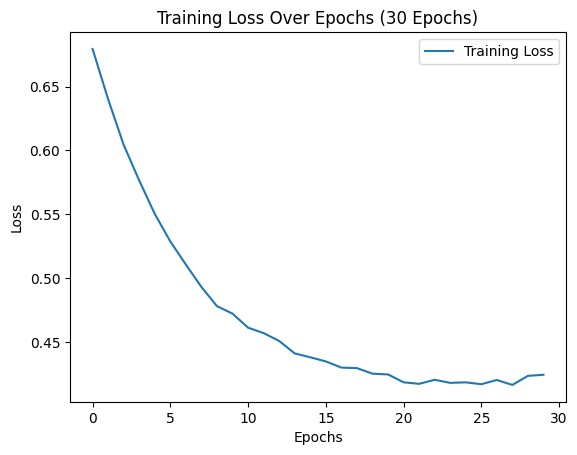

In [ ]:
#TO-DO: Increase epochs to 30 and re-train the network
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
#TO-DO: Plot the larning curve for the training data
training_loss = history.history['loss'] # Get the training loss from history

# Plot the learning curve
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (30 Epochs)')
plt.legend()
plt.show()
# This shows us the learning curve because if the training loss decreases over the epochs, the model is learning

#TO-DO: Describe the change in the output when you change from 20 epochs to 30 epochs
#ANSWER: The training loss, even from the very first epoch, starts much lower than what we had at the very end of
#the 20 epochs training loss graph. This graph does show a slight bump at the end where it seems like training loss
#is starting to increase instead of decrease but because it happens at the very end (until about epoch 28), it is not
#a huge concern. The shape of the two graphs (from 20 epochs and this one for 30 epochs) has a very similar growth
#rate where it rapidly decreases at first and then the training loss decrease at a slower rate.

In [ ]:
#TO-DO: Generate text using the re-trained network
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to Juliet
start = time.time()
states = None
next_char = tf.constant(['JULIET:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to Hamlet
start = time.time()
states = None
next_char = tf.constant(['HAMLET:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to Macbeth
start = time.time()
states = None
next_char = tf.constant(['MACBETH:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to OTHELLO
start = time.time()
states = None
next_char = tf.constant(['OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Compare generated texts than those generated with 20 epochs.
#The sentiment appears to be much clearer and the coherence of the sentences are much
#better now. These texts have a lot more Shakespeare-like qualities however a
#contributing factor to that may related to the fact that the coherence increased.
#Overall, these texts are a lot more understandable and Shakespeare-like.

ROMEO:
This cheat appointment like successions, finds you have
labentant.

Provost:

ISABELLA:
When blessed lady?

RATCLIFF:
Neither better knows not: more villains! well may never saw
He fastes rage and wonder, for her custom
Is cold to can thy good upon this earth,
Some say this tyrannot of this business.

LEONTES:
No, in good earnest! do it please you, sir, go with me
To swear at all, and spare me speak me; for a vice thy house
To murder me by the schover of my foe.
The mighty starved figure of this isle with Merby, and
Her friends a heavy sad desire
Musture their for than a devousing means,
Stabbed and sleep underness I had gone forth.

CAPULET:
A jealous hood, a tay to levy methine her foul thou art:
Then, as She had a man would pray with royal house,
By strangling up of justice word for water,
To make the law and her eyes bid the morning of my oath
And damnaments not out of fools; but have heard dreams
Berry about him: you have any such life on me
And carry factions one that know

If you want the model to generate text *faster* the easiest thing you can do is batch the text generation. In the example below the model generates 5 outputs in about the same time it took to generate 1 above.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThis cannot be avey.\nOf honourable reckoning a fearful soul\nAs I had heard in harse than the Tribunes.\n'Lake a broad, but as far from him forth\nTo the possession of my cry!\n\nMARCIUS:\n'Side as we are.\n\nLUCENTIO:\nTrue; nor not honest: I never saw a better harn back.\n\nLADY CAPULET:\nWhat noise is there?\n\nGLOUCESTER:\nUpon thy kingdom and herself\nHarkless near'd at our power: I, after had I chose yourself.\nYou have you ever the coffers of my smilerate:\nA man of those that should be contented.\n\nPRINCE EDWARD:\nNo, Warwick, there I live in Rome to Lord Angelo?\n\nISABELLA:\nO plague o' blessed Marcius,\nOh the opposite of ill time of your\nare: let's on a happy told show from\nThe accuser and of mine own charge ho.\n\nRUCHENR OF YORK:\nWhat lords, like antioner than thy life,\nIf he very wealth cover liuge all dead.\n\nGLOUCESTER:\nUpon what man thou comest, and, Will I behold my rough:\nTherefore, hail! I till thou art taken whilst thou soon,\nYou ha

## Export the generator

This single-step model can easily be [saved and restored](https://www.tensorflow.org/guide/saved_model), allowing you to use it anywhere a `tf.saved_model` is accepted.

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
This cheap is nothing, both your boostrance.

DUCHESS OF YORK:
Why, this it is, when men are at the


# Adding another RNN layer

In [ ]:
#TO-DO: add another RNN layer
# Adding separately so both results can be seen
class AddLayerModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru1.get_initial_state(x)
    x, states = self.gru2(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

model = AddLayerModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

# need to set the necessary flag as specified earlier
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam', loss=loss)

one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Epoch 1/20
172/172 [==============================] - 18s 56ms/step - loss: 2.7206
Epoch 2/20
172/172 [==============================] - 11s 56ms/step - loss: 1.9909
Epoch 3/20
172/172 [==============================] - 11s 55ms/step - loss: 1.7138
Epoch 4/20
172/172 [==============================] - 12s 57ms/step - loss: 1.5509
Epoch 5/20
172/172 [==============================] - 11s 57ms/step - loss: 1.4507
Epoch 6/20
172/172 [==============================] - 12s 59ms/step - loss: 1.3819
Epoch 7/20
172/172 [==============================] - 12s 59ms/step - loss: 1.3291
Epoch 8/20
172/172 [==============================] - 12s 57ms/step - loss: 1.2837
Epoch 9/20
172/172 [==============================] - 11s 56ms/step - loss: 1.2423
Epoch 10/20
172/172 [==============================] - 11s 57ms/step - loss: 1.2031
Epoch 11/20
172/172 [==============================] - 11s 57ms/step - loss: 1.1639
Epoch 12/20
172/172 [==============================] - 12s 58ms/step - loss: 1.1224
E

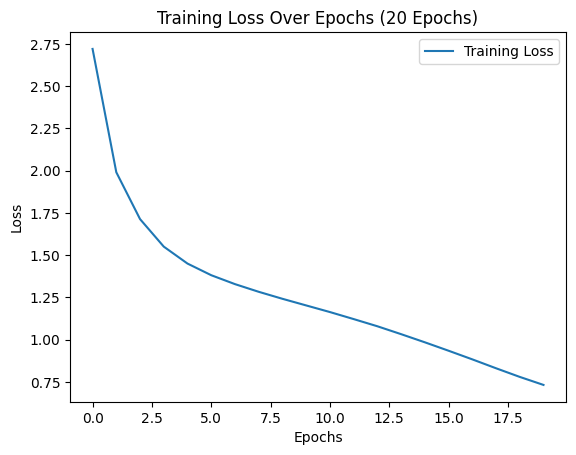

ROMEO:
Good queen,
That talk'd of late! why, Clarence?

ANGELO:
Let them supple the Appostion of your daughter.

LADTIA:
Then it was brought to be consented
Than a notlerfuck-grasty dogg'st callet of free;
And answer'd not on't, we will rewards disorch'd
The fruit-disposing in it is becomed.

PETRUCHIO:
Wherefore, Peterbur, these thy heads of thee,
Or any choice of the devil.--O, then,
God save thee, Kate, what says he more
Than did forth flowers of constant and such
Toads deserved all given his house,
As you wishing metitors, but one grave spirit,
Poor livery of the dead.

SAMPSON:
Nay, good my lord.

LEONTES:
You said of all, because that, when, be jolice,
Thou canst not spirits any trick told me
It chance to ender is the east, might our wit,
Rich half did scale in hell.

LUCIO:
I took thee for a good as at least.

GOLZAL:
I saw him good;
Poor heart, of all my joy is letter then.

BIANCA:
How shall answer mistruse out of thing to get a husband:
I wish my enforced imagination
To beg o

In [ ]:
#TO-DO: Repeat checking the model with 20 epochs and 30 epochs given the new model
# 20 epochs
EPOCHS = 20

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
#TO-DO: Plot the larning curve for the training data
training_loss = history.history['loss'] # Get the training loss from history

# Plot the learning curve
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (20 Epochs)')
plt.legend()
plt.show()
# This shows us the learning curve because if the training loss decreases over the epochs, the model is learning

#TO-DO: Generated text as well
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to Juliet
start = time.time()
states = None
next_char = tf.constant(['JULIET:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to Hamlet
start = time.time()
states = None
next_char = tf.constant(['HAMLET:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to Macbeth
start = time.time()
states = None
next_char = tf.constant(['MACBETH:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to OTHELLO
start = time.time()
states = None
next_char = tf.constant(['OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Epoch 1/30
172/172 [==============================] - 12s 58ms/step - loss: 0.6885
Epoch 2/30
172/172 [==============================] - 12s 59ms/step - loss: 0.6500
Epoch 3/30
172/172 [==============================] - 12s 60ms/step - loss: 0.6130
Epoch 4/30
172/172 [==============================] - 12s 58ms/step - loss: 0.5814
Epoch 5/30
172/172 [==============================] - 11s 57ms/step - loss: 0.5556
Epoch 6/30
172/172 [==============================] - 11s 56ms/step - loss: 0.5355
Epoch 7/30
172/172 [==============================] - 11s 57ms/step - loss: 0.5178
Epoch 8/30
172/172 [==============================] - 12s 59ms/step - loss: 0.5012
Epoch 9/30
172/172 [==============================] - 12s 58ms/step - loss: 0.4881
Epoch 10/30
172/172 [==============================] - 12s 58ms/step - loss: 0.4754
Epoch 11/30
172/172 [==============================] - 13s 58ms/step - loss: 0.4668
Epoch 12/30
172/172 [==============================] - 12s 57ms/step - loss: 0.4587
E

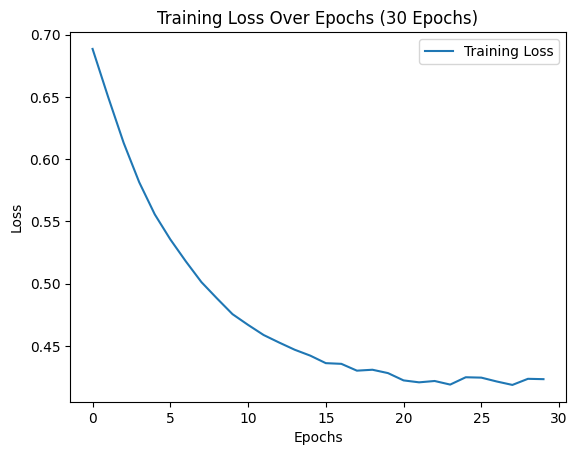

ROMEO:
The mother, like a bawd. Ourself must not be?
Faith, now we are generation.

GREGORY:
So I am, pray you.

AUTOLYCUS:
Very true, fair quarrel, for this afternoon:
And now my flindry warrant, an irgan'd glass,
There stays hath lecture to mock my heaven and
the king. Provost, thou hadst, and must none entertain
Than misery prover to'er here.

GLOUCESTER:
Her name this bloody day hath loved a man he can
her false flight and advice their title of your own versel
May spraylibred his spirit tought:
My name is most; and then from the mind of those woes,
who shall be mine? are it your power?

COMINIUS:
Your highness shall do you for this intelligence to her.

QUEEN ELIZABETH:
I have father hed to-day pronounce, here stumble.

GLOUCESTER:
He hath not sometime twice o'erwhere let us sure usure;
Our traitors do him go the French to't,
We should have hold me in his stafe to do in's absence.

HESS OF YORK:
I will to my reposity, where we came?

Second Murderer:
I fouler than your father's hau

In [ ]:
#TO-DO: Repeat checking the model with 20 epochs and 30 epochs given the new model
# 30 epochs
EPOCHS = 30

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
#TO-DO: Plot the larning curve for the training data
training_loss = history.history['loss'] # Get the training loss from history

# Plot the learning curve
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (30 Epochs)')
plt.legend()
plt.show()
# This shows us the learning curve because if the training loss decreases over the epochs, the model is learning

#TO-DO: Generated text as well
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to Juliet
start = time.time()
states = None
next_char = tf.constant(['JULIET:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to Hamlet
start = time.time()
states = None
next_char = tf.constant(['HAMLET:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to Macbeth
start = time.time()
states = None
next_char = tf.constant(['MACBETH:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

#TO-DO: Change Romeo to OTHELLO
start = time.time()
states = None
next_char = tf.constant(['OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

# Question 4's answers are detailed in the text block below

ANSWER: CHANGES NOTED FROM WITH THE ADDITIONAL LAYER VERSUS WITHOUT:
- The learning curve graph seems to be similar to the one without the additional layer for 20 epochs
- With 30 epochs, the learning curve starts at a greater training loss which reduces to roughly the same as without the additional layer but the one without the additional layer seems to reach that lower training loss quicker although they were pretty close
- As for the generated text, it appears to have the same discussion as what was shwon earlier without the additional layer, except perhaps the coherence might have increased a bit which cleared up the sentiment as well.

## Advanced: Customized Training

The above training procedure is simple, but does not give you much control.
It uses teacher-forcing which prevents bad predictions from being fed back to the model, so the model never learns to recover from mistakes.

So now that you've seen how to run the model manually next you'll implement the training loop. This gives a starting point if, for example, you want to implement _curriculum  learning_ to help stabilize the model's open-loop output.

The most important part of a custom training loop is the train step function.

Use `tf.GradientTape` to track the gradients. You can learn more about this approach by reading the [eager execution guide](https://www.tensorflow.org/guide/eager).

The basic procedure is:

1. Execute the model and calculate the loss under a `tf.GradientTape`.
2. Calculate the updates and apply them to the model using the optimizer.

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

The above implementation of the `train_step` method follows [Keras' `train_step` conventions](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit). This is optional, but it allows you to change the behavior of the train step and still use keras' `Model.compile` and `Model.fit` methods.

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 14s 59ms/step - loss: 2.7293


Or if you need more control, you can write your own complete custom training loop:

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1771
Epoch 1 Batch 50 Loss 2.0380
Epoch 1 Batch 100 Loss 1.9396
Epoch 1 Batch 150 Loss 1.8724

Epoch 1 Loss: 2.0049
Time taken for 1 epoch 12.73 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.7914
Epoch 2 Batch 50 Loss 1.7876
Epoch 2 Batch 100 Loss 1.7110
Epoch 2 Batch 150 Loss 1.6785

Epoch 2 Loss: 1.7334
Time taken for 1 epoch 11.35 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5806
Epoch 3 Batch 50 Loss 1.6533
Epoch 3 Batch 100 Loss 1.5787
Epoch 3 Batch 150 Loss 1.5363

Epoch 3 Loss: 1.5701
Time taken for 1 epoch 11.19 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4633
Epoch 4 Batch 50 Loss 1.4868
Epoch 4 Batch 100 Loss 1.5270
Epoch 4 Batch 150 Loss 1.4470

Epoch 4 Loss: 1.4679
Time taken for 1 epoch 11.05 sec
_____________________________________________________________________